In [1]:
from autqec.graph_auts import *
from autqec.automorphisms import *
from autqec.ZX_dualities import *
from autqec.utils.qec import *
from autqec.utils.qiskit import *

from time import time

## Background

Unless stated otherwise, we have used **code automorphisms** to find fault-tolerant logical Clifford gates of codes. 

For small codes (n < 360), this method works well and code automorphisms can be found by Leon’s algorithm. For larger codes, we can instead consider **check matrix automorphisms**. Check matrix automorphisms are a subgroup of the code automorphism group. This is because a check matrix automorphism maps each stabiliser generator to another, rather than to products of stabilizer generators. To compute check matrix automorphisms efficiently, we map them to their Tanner graphs and compute the **graph automorphisms**. 

# Example - [[4,2,2]] code
The [[4,2,2]] code has a code automorphism group of order 144 (see `examples/[[4,2,2]].ipynb`). In the following we calculate graph automorphisms.

In [2]:
# Define code
n = 4
k = 2 
d = 2
stabs = ['XXXX','ZZZZ']
H_symp = stabs_to_H_symp(stabs)
H_3bit = np.hstack([H_symp,(H_symp[:,:n]+H_symp[:,n:])%2]) # adding XZ block 
H_3bit = np.vstack([H_3bit,(H_3bit[0,:]+H_3bit[1,:])%2]) # adding the YYYY stabilizer

### Find graph auts:

In [3]:
auts = valid_clifford_auts(H_3bit,bits_3=True) # computes graph auts that correspond to a physical Clifford operation

Order: 144


When the YYYY stabilizer is included in the parity check matrix, the graph automorphisms match the code automorphisms for this code. Let us now run AutQEC algorithms to find the logical circuits of the graph automorphisms. 

In [4]:
circuits = []
symp_mats = []
for num, aut in enumerate(auts):
    phys_act = circ_from_aut(H_symp,aut)        
    phys_circ, _ = phys_act.circ()
    log_act = logical_circ_and_pauli_correct(H_symp,phys_circ)
    circ = log_act.run()
    circuits.append(circ)
    symp_mats.append(log_act.U_logical_act())

Visualization of one of the generators:

Logical action: [('CZ', (1, 2))]


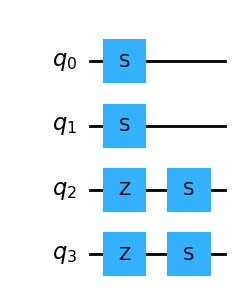

In [5]:
# example physical circuit and logical action
circ = circuits[0]
print('Logical action:',circ[0])
qc = construct_circuit(circ[1], n)
qc.draw(output='mpl')

## Example - [[[756,16,34]]]

Let us now try finding the graph automorphisms of a large Bivariate Bicycle Code. 

In [6]:
n = 756
k = 16
d = 34

H_X = np.load(f'./bivariate_bicycle_codes/code_data/HX_n{n}k{k}d{d}.npy')
H_Z = np.load(f'./bivariate_bicycle_codes/code_data/HZ_n{n}k{k}d{d}.npy')

zeros = np.zeros_like(H_X)
H_symp = np.array(np.vstack((np.hstack((H_X,zeros)),np.hstack((zeros,H_Z)))),dtype=int)

In [7]:
H_symp_rref, _, transform_rows, transform_cols = rref_mod2(H_symp)
H_symp_rref = H_symp_rref[~np.all(H_symp_rref == 0, axis=1)]
H_symp_rref_og_basis = H_symp_rref@inv_mod2(transform_cols)
assert H_symp_rref_og_basis.shape[0] == n-k
assert H_symp_rref_og_basis.shape[1] == 2*n

In [8]:
t0 = time()
H_3bit = np.hstack([H_symp,(H_symp[:,:n]+H_symp[:,n:])%2])
auts = valid_clifford_auts_B_rows(H_3bit,bits_3=True,return_order=True)
t1 = time()
print('Time taken:',t1-t0)

Order: 756
Time taken: 0.33637499809265137


In [9]:
circuits = []
symp_mats = []
for num, aut in enumerate(auts):
    phys_act = circ_from_aut(H_symp_rref_og_basis,aut)        
    phys_circ, _ = phys_act.circ()
    log_act = logical_circ_and_pauli_correct(H_symp_rref_og_basis,phys_circ)
    circ = log_act.run()
    circuits.append(circ)
    symp_mats.append(log_act.U_logical_act())

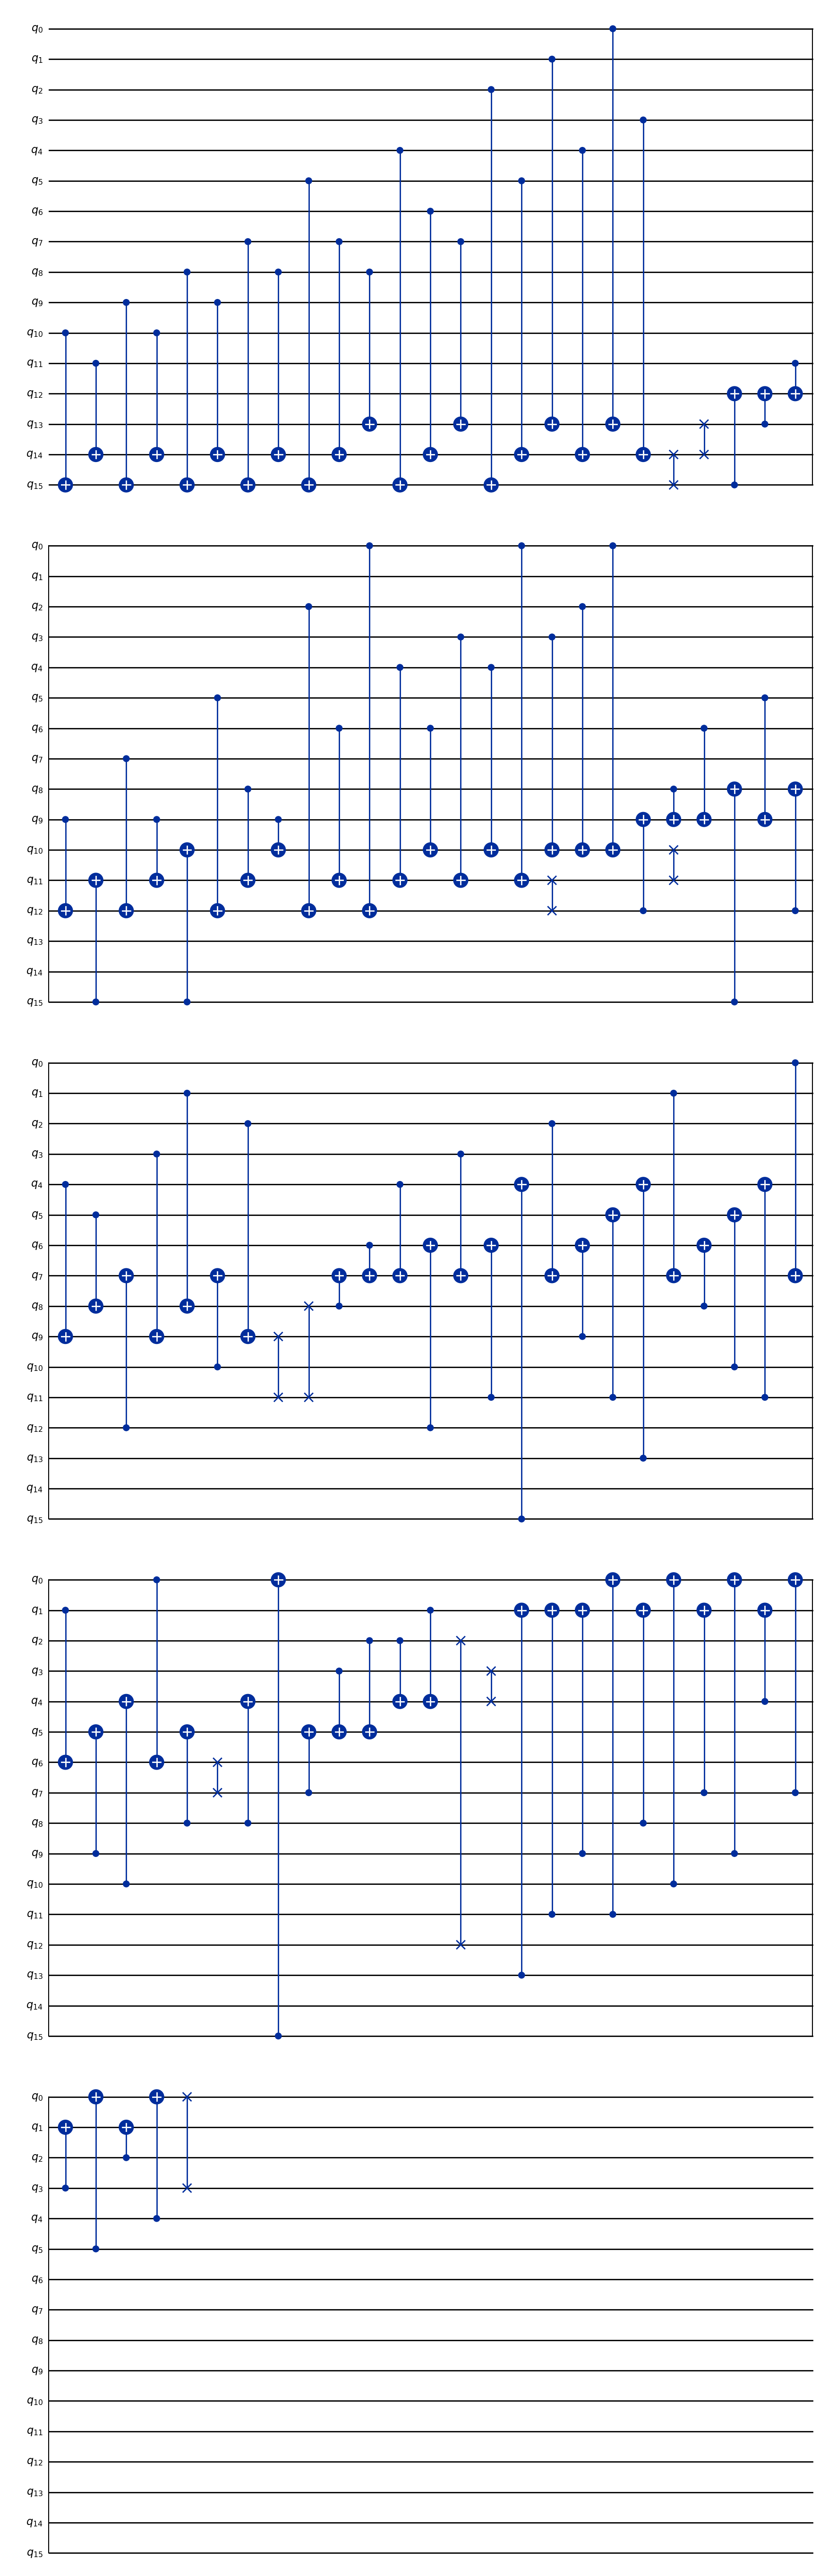

In [11]:
# example logical action
circ = circuits[0]
qc = construct_circuit(circ[0], k)
qc.draw(output='mpl')